## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import KFold, cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb

data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
data = data.resample('1H').sum()

display(data.head(10))

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Ресемплировали данные по часу и поместили часы в индекс, в следствие того что при ресемплировании взяли среднее значение переменная стала непрерывной и у нас стали возможными, например, 20 с половиной заказов такси в 12 часов ночи

# 2. Анализ

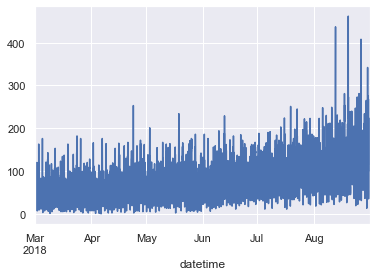

In [2]:
data['num_orders'].plot()

График не особо информативен, думаю стоит перестроить его по скользящему среднему, но для начала подготовим признаки для модели

Text(0.5, 1.0, 'Trend')

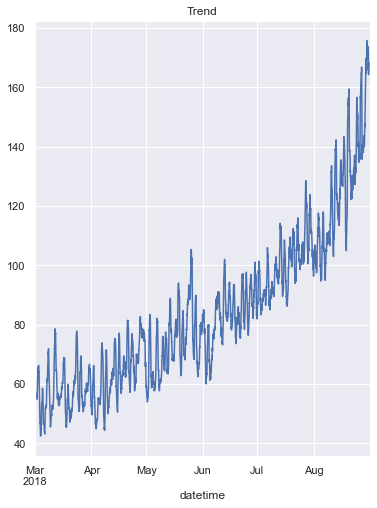

In [3]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

Тренд показывает примерно то же что и скользящее среднее ниже - восходящий к концу августа график

Text(0.5, 1.0, 'Seasonality')

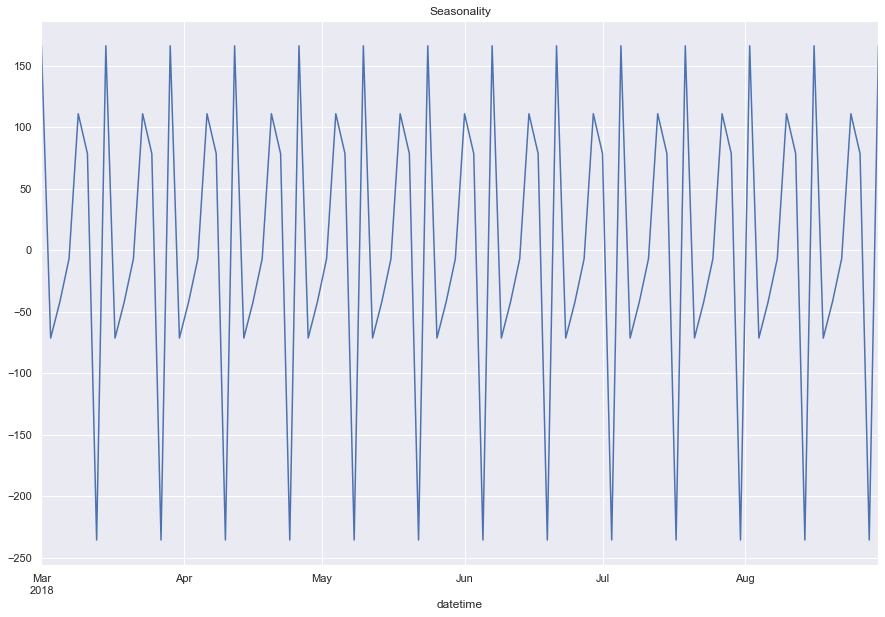

In [4]:
dota = data.resample('2D').sum()
decomposed = seasonal_decompose(dota)
plt.figure(figsize=(15, 10))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

Ресемплил по двум дням чтобы график стал хоть сколько-нибудь информативным, по сути мы видим что из недели в неделю у нас одинаковая картина - падение графика во вторник и субботу, и высокий рост в вс-пн и приблизительно в пятницу

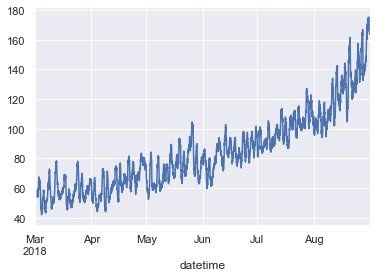

In [5]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['rolling_mean'] = data['rolling_mean'].dropna()

make_features(data, 65, 25)
data['rolling_mean'].plot()

Высчитав скользящее среднее видим что в конце августа 2018 заказов такси почти в 3 раза больше чем в начале марта, хотя конечно нельзя уверенно сказать что тут причина в сезоне, ведь могут быть и другие причины

P.S. Скользящее среднее в некоторых местах создаёт пропуски, но так как это временные ряды думаю корректно эти пропуски заполнить ближайшим (сзади) известным значением

# 3. Обучение

In [6]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

train_y = train['num_orders']
train_x = train.drop('num_orders', axis=1)

test_y = test['num_orders']
test_x = test.drop('num_orders', axis=1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Разделили выборку на трейн-тест

In [7]:
tscv = TimeSeriesSplit()

train_x = train_x.fillna(0)

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, train_x, train_y, scoring="neg_mean_squared_error", cv=tscv))
    return (rmse)

dummy_regr = DummyRegressor(strategy='mean')

print(f'Dummy Regressor RMSE: {cv_rmse(dummy_regr).mean()}')

Dummy Regressor RMSE: 40.469105309309214


Dummy выдаёт достаточно низкое RMSE чтобы сдать работу, но вряд ли это повторится на тест выборке

In [10]:
lin_reg = LinearRegression()

print(f'Linear Regression RMSE: {cv_rmse(lin_reg).mean()}')

Linear Regression RMSE: 638738705486.1705


In [9]:
super_tree = DecisionTreeRegressor(random_state=123, max_depth=6)

print(f'Tree RMSE: {cv_rmse(super_tree).mean()}')

Tree RMSE: 30.709007291252817


In [11]:
lgbm = lgb.LGBMRegressor(n_estimators=500)

print(f'LGBM RMSE: {cv_rmse(lgbm).mean()}')

LGBM RMSE: 24.634582873534733


Ожидаемо LGBM выдал лучший результат

Гиперпараметры подбирал "за кулисами", потому что гридсёрч адово увеличивает время работы ноутбука, да и тем более ручками когда алгоритм быстро работает намного быстрее попробовать некоторые параметры.

Почему конкретно в этом случае RMSE лгбм'а падает при любых других изменениях параметров кроме количества estimators

# 4. Тестирование

In [11]:
model = lgb.LGBMRegressor(n_estimators=500)

model.fit(train_x, train_y)
answers = model.predict(test_x)

(f"Тестовое RMSE: {mean_squared_error(test_y, answers) ** 0.5}")

'Тестовое RMSE: 39.38524947202281'

# Вывод

LGBM регрессор показал лучшие результаты как на стадии валидации так и на тесте, также мною отмечено большое влияние количества лагов на итоговую метрику. При количестве лагов в 65 удалось достичь значения RMSE в размере 39.3